<a href="https://colab.research.google.com/github/alisanyalcinn/object-detection-YOLO/blob/main/YOLO_with_image_resizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install -q kaggle ultralytics lxml

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alianyaln","key":"887656a8cc60f125307147d8503f4e4f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p ./data/pascal_voc
!kaggle datasets download -d sulaimannadeem/pascal-voc-2008
!unzip -q pascal-voc-2008.zip -d ./data/pascal_voc

Dataset URL: https://www.kaggle.com/datasets/sulaimannadeem/pascal-voc-2008
License(s): unknown
 99% 523M/529M [00:01<00:00, 283MB/s]
100% 529M/529M [00:01<00:00, 395MB/s]


In [ ]:
import os
import cv2
import shutil
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
image_dir = "/content/data/pascal_voc/Pascal Dataset/JPEGImages"
annotation_dir = "/content/data/pascal_voc/Pascal Dataset/Annotations"
output_dir = "/content/data/pascal_voc_yolo"

In [ ]:
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/{split}", exist_ok=True)

In [ ]:
def convert_bbox(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w, h = box[1] - box[0], box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

In [ ]:
image_files = glob(f"{image_dir}/*.jpg")
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

In [ ]:
def copy_and_preprocess_images(file_list, split):
    for file_path in file_list:
        filename = os.path.basename(file_path)
        img = cv2.imread(file_path)
        if img is None:
            continue
        # Resize to 416x416 and normalize pixel values
        img = cv2.resize(img, (416, 416))
        img = (img / 255.0 * 255).astype(np.uint8)  # maintain valid range for saving
        out_path = f"{output_dir}/images/{split}/{filename}"
        cv2.imwrite(out_path, img)

In [ ]:
copy_and_preprocess_images(train_files, "train")
copy_and_preprocess_images(val_files, "val")
copy_and_preprocess_images(test_files, "test")

In [ ]:
classes = []

In [ ]:
def convert_annotation(image_path, split):
    filename = os.path.basename(image_path).replace(".jpg", "")
    xml_path = os.path.join(annotation_dir, filename + ".xml")
    label_path = os.path.join(output_dir, f"labels/{split}/{filename}.txt")

    if not os.path.exists(xml_path):
        print(f"⚠️ Missing annotation: {xml_path}")
        return

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find("size")
        w, h = float(size.find("width").text), float(size.find("height").text)

        with open(label_path, 'w') as out_file:
            for obj in root.iter("object"):
                cls = obj.find("name").text
                if cls not in classes:
                    classes.append(cls)
                cls_id = classes.index(cls)
                xmlbox = obj.find("bndbox")
                b = [float(xmlbox.find(tag).text) for tag in ["xmin", "xmax", "ymin", "ymax"]]
                bb = convert_bbox((w, h), b)
                out_file.write(f"{cls_id} " + " ".join([f"{a:.6f}" for a in bb]) + "\n")
    except Exception as e:
        print(f"❌ Error parsing {xml_path}: {e}")

def process_split(split):
    img_dir = os.path.join(output_dir, f"images/{split}")
    image_files = glob(f"{img_dir}/*.jpg")
    print(f"Processing {split}: {len(image_files)} images")
    for img_path in image_files:
        convert_annotation(img_path, split)

In [ ]:
for split in ["train", "val", "test"]:
    process_split(split)

Processing train: 3567 images
Processing val: 764 images
Processing test: 765 images


In [ ]:
data_yaml_content = f"""
train: {output_dir}/images/train
val: {output_dir}/images/val
test: {output_dir}/images/test

nc: {len(classes)}
names: {classes}
"""

In [ ]:
yaml_path = os.path.join(output_dir, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml_content)

In [ ]:
with open(yaml_path, "r") as f:
    print(f.read())


train: /content/data/pascal_voc_yolo/images/train
val: /content/data/pascal_voc_yolo/images/val
test: /content/data/pascal_voc_yolo/images/test

nc: 20
names: ['person', 'bicycle', 'car', 'cat', 'motorbike', 'boat', 'aeroplane', 'dog', 'tvmonitor', 'horse', 'bird', 'sofa', 'bus', 'chair', 'diningtable', 'pottedplant', 'bottle', 'sheep', 'train', 'cow']



In [22]:
model = YOLO("yolov8s.pt")
model.train(
    data=yaml_path,
    epochs=5,
    imgsz=416,
    batch=16,
    name="yolov8_pascal_voc"
)

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/pascal_voc_yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_pascal_voc2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

train: Scanning /content/data/pascal_voc_yolo/labels/train.cache... 3567 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3567/3567 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 540.7±434.9 MB/s, size: 57.2 KB)


val: Scanning /content/data/pascal_voc_yolo/labels/val.cache... 764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8_pascal_voc2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8_pascal_voc2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.022      1.906      1.234         72        416: 100%|██████████| 223/223 [1:06:49<00:00, 17.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:19<00:00, 13.31s/it]


                   all        764       2055      0.765      0.558      0.664      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.041      1.465      1.241         71        416: 100%|██████████| 223/223 [1:06:38<00:00, 17.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:13<00:00, 13.08s/it]

                   all        764       2055      0.665       0.58       0.63      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.048      1.468      1.249        116        416: 100%|██████████| 223/223 [1:06:56<00:00, 18.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:15<00:00, 13.17s/it]

                   all        764       2055      0.643      0.568      0.621      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G          1      1.324      1.232         66        416: 100%|██████████| 223/223 [1:06:26<00:00, 17.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:08<00:00, 12.85s/it]

                   all        764       2055      0.714      0.581      0.661      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.9539      1.192      1.202         80        416: 100%|██████████| 223/223 [1:07:20<00:00, 18.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [05:08<00:00, 12.84s/it]

                   all        764       2055       0.71      0.646       0.71      0.531



5 epochs completed in 6.006 hours.
Optimizer stripped from runs/detect/yolov8_pascal_voc2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_pascal_voc2/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_pascal_voc2/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [04:43<00:00, 11.82s/it]


                   all        764       2055      0.708      0.648       0.71      0.531
                person        360        781      0.898      0.786      0.874      0.658
               bicycle         28         34      0.869      0.781      0.827       0.58
                   car         72        140      0.741      0.737       0.79      0.585
                   cat         72         82      0.816      0.817      0.879      0.755
             motorbike         36         52      0.851      0.769       0.86       0.55
                  boat         39         75      0.661      0.571      0.594      0.373
             aeroplane         33         54      0.796       0.65      0.683       0.54
                   dog         62         76      0.703      0.671      0.765      0.617
             tvmonitor         44         53      0.691      0.755      0.806      0.655
                 horse         44         63      0.842      0.651      0.823       0.62
                  bir

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793af4b21990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [23]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

In [26]:
model_path = os.path.join("runs", "detect", "yolov8_pascal_voc2", "weights", "best.pt")
model = YOLO(model_path)

In [27]:
eval_results = model.val(data=f"{output_dir}/data.yaml")
print("\n📊 Evaluation Results:")
print(eval_results)

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1107.5±287.8 MB/s, size: 75.8 KB)


val: Scanning /content/data/pascal_voc_yolo/labels/val.cache... 764 images, 0 backgrounds, 0 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [04:44<00:00,  5.93s/it]


                   all        764       2055      0.708      0.648       0.71      0.531
                person        360        781      0.898      0.786      0.874      0.658
               bicycle         28         34      0.869      0.781      0.827       0.58
                   car         72        140      0.741      0.737       0.79      0.585
                   cat         72         82      0.816      0.817      0.879      0.755
             motorbike         36         52      0.851      0.769       0.86       0.55
                  boat         39         75      0.661      0.571      0.594      0.373
             aeroplane         33         54      0.796       0.65      0.683       0.54
                   dog         62         76      0.703      0.671      0.765      0.617
             tvmonitor         44         53      0.691      0.755      0.806      0.655
                 horse         44         63      0.842      0.651      0.823       0.62
                  bir

In [28]:
test_images = glob(f"{output_dir}/images/test/*.jpg")[:5]
results = model(test_images)


0: 416x416 1 aeroplane, 825.0ms
1: 416x416 2 persons, 825.0ms
2: 416x416 1 aeroplane, 825.0ms
3: 416x416 (no detections), 825.0ms
4: 416x416 2 birds, 825.0ms
Speed: 3.0ms preprocess, 825.0ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 416)


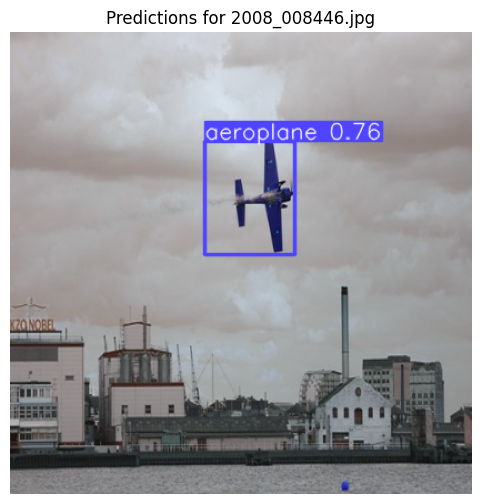

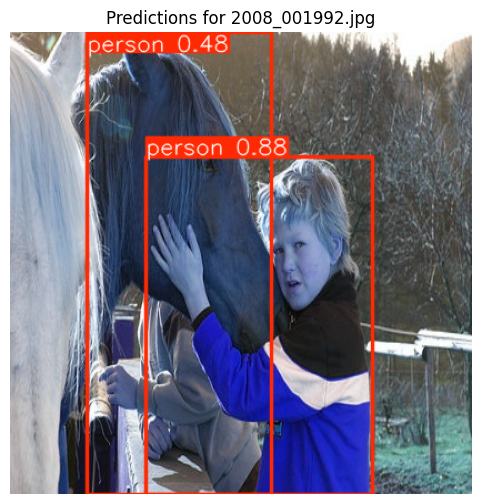

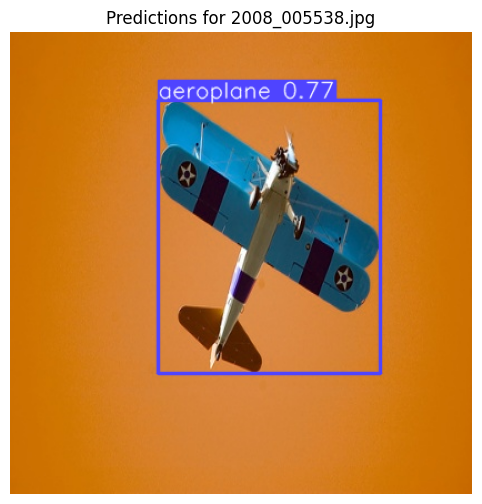

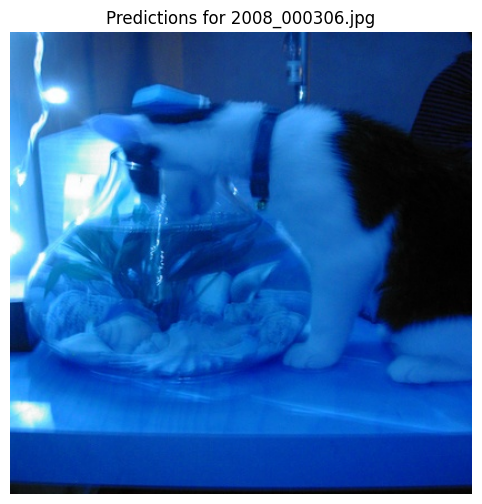

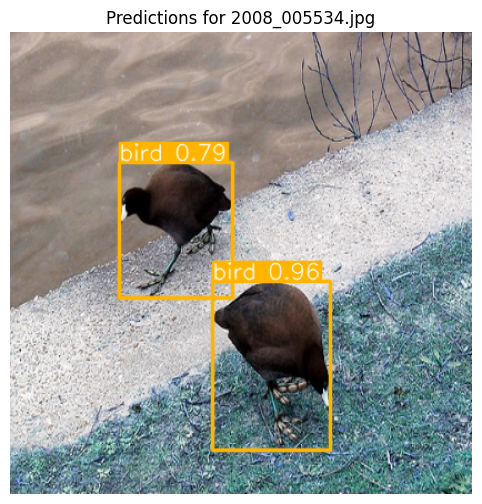

In [29]:
for img_path, result in zip(test_images, results):
    im_array = result.plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(im_array)
    plt.title(f"Predictions for {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()